In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Dependencies

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-u5asvjn1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-u5asvjn1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import time
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split  # Added for splitting
from transformers import AutoTokenizer
import clip

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
!pip install madgrad

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.optim import AdamW
from madgrad import MADGRAD

## Dataset Notebook

In [ ]:
def balanced_weigths(data):
    # Ensure labels are integers
    y = data['Labels'].astype(int)
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    return class_weights

In [ ]:
class BHMDataset(Dataset):
    def __init__(self, dataframe, tokenizer, data_dir, max_seq_length, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.max_seq_length = max_seq_length
        self.data_dir = data_dir
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 1. Load Image
        img_filename = self.data.loc[idx, 'image_name']
        img_path = os.path.join(self.data_dir, img_filename)

        # Open and convert to RGB (handles PNGs with transparency issues)
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, FileNotFoundError):
            # Fallback for missing images - create black image
            print(f"Warning: Could not open {img_path}. Using blank image.")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # 2. Load Text
        caption = str(self.data.loc[idx, 'Captions'])

        # 3. Load Label
        label = int(self.data.loc[idx, 'Labels'])

        if self.transform:
            image = self.transform(image)

        # Tokenize
        inputs = self.tokenizer(caption, return_tensors='pt',
                                padding='max_length', truncation=True, max_length=self.max_seq_length)

        return {
            'image': image,
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': label
        }

In [ ]:
# # Datasets.py

# def load_dataset_merged(csv_file_path, memes_path, max_len, batch_size):
#     print(f"Loading Single Merged Dataset from {csv_file_path}...")
#     print("Splitting: 80% Train / 20% Val")

#     # 1. Read the Single CSV
#     df = pd.read_csv(csv_file_path)

#     # 2. Rename columns to match BHMDataset expectations
#     # Your CSV has: 'Image_name', 'extracted_text', 'Label'
#     # BHMDataset needs: 'image_name', 'Captions', 'Labels'

#     df = df.rename(columns={
#         'Image_name': 'image_name',      # Fixes capitalization
#         'normalized_corpus': 'Captions',    # Maps text column
#         'Label': 'Labels'                # Maps label column
#     })

#     # 3. Handle Missing Text
#     df['Captions'] = df['Captions'].fillna("")

#     # 4. Map Labels (Binary)
#     # Ensure your CSV uses "NonPolitical" and "Political" exactly
#     label_map = {"NonPolitical": 0, "Political": 1}
#     df['Labels'] = df['Labels'].map(label_map)

#     # Drop rows where label mapping failed (e.g., if there's a typo in the CSV)
#     df = df.dropna(subset=['Labels'])

#     # 5. Split Data (80% Train, 20% Validation)
#     # We stratify by 'Labels' to keep the ratio of Political/NonPolitical consistent
#     train_df, val_df = train_test_split(
#         df,
#         test_size=0.20,
#         random_state=42,
#         stratify=df['Labels']
#     )

#     print(f"Total Samples: {len(df)}")
#     print(f"Training Samples: {len(train_df)}")
#     print(f"Validation Samples: {len(val_df)}")

#     # 6. Weights & Tokenizer
#     # Calculate weights to handle class imbalance
#     weights = balanced_weigths(train_df)

#     tokenizer = AutoTokenizer.from_pretrained("facebook/xglm-564M")

#     data_transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])

#     # 7. Create Loaders
#     train_dataset = BHMDataset(dataframe=train_df, tokenizer=tokenizer, data_dir=memes_path,
#                                max_seq_length=max_len, transform=data_transform)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#     val_dataset = BHMDataset(dataframe=val_df, tokenizer=tokenizer, data_dir=memes_path,
#                              max_seq_length=max_len, transform=data_transform)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     # Return only train, val, and weights
#     return train_loader, val_loader, weights

In [ ]:
# Datasets.py

def load_dataset_merged(csv_file_path, memes_path, max_len, batch_size):
    print(f"Loading Single Merged Dataset from {csv_file_path}...")
    print("Splitting: 70% Train / 15% Val / 15% Test")

    # 1. Read the Single CSV
    df = pd.read_csv(csv_file_path)

    # 2. Rename columns to match BHMDataset expectations
    df = df.rename(columns={
        'Image_name': 'image_name',
        'normalized_corpus': 'Captions',
        'Label': 'Labels'
    })

    # 3. Handle Missing Text
    df['Captions'] = df['Captions'].fillna("")

    # 4. Map Labels (Binary)
    label_map = {"NonPolitical": 0, "Political": 1}
    df['Labels'] = df['Labels'].map(label_map)
    df = df.dropna(subset=['Labels'])

    # 5. Split Data (70-15-15)
    # Step 1: Split into Train (70%) and Temp (30%)
    train_df, temp_df = train_test_split(
        df,
        test_size=0.30,
        random_state=42,
        stratify=df['Labels']
    )

    # Step 2: Split Temp (30%) into Val (15%) and Test (15%)
    # Since 0.15 is half of 0.30, we use test_size=0.5 on the temp_df
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.50,
        random_state=42,
        stratify=temp_df['Labels']
    )

    print(f"Total Samples: {len(df)}")
    print(f"Training Samples: {len(train_df)}")
    print(f"Validation Samples: {len(val_df)}")
    print(f"Test Samples: {len(test_df)}")

    # 6. Weights & Tokenizer
    weights = balanced_weigths(train_df)
    tokenizer = AutoTokenizer.from_pretrained("facebook/xglm-564M")

    # Transforms (Val and Test use the same standard transform)
    data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # 7. Create Loaders
    train_dataset = BHMDataset(dataframe=train_df, tokenizer=tokenizer, data_dir=memes_path,
                               max_seq_length=max_len, transform=data_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = BHMDataset(dataframe=val_df, tokenizer=tokenizer, data_dir=memes_path,
                             max_seq_length=max_len, transform=data_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = BHMDataset(dataframe=test_df, tokenizer=tokenizer, data_dir=memes_path,
                             max_seq_length=max_len, transform=data_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Return Train, Val, Test, and Weights
    return train_loader, val_loader, test_loader, weights

## Architecture

In [ ]:
from torch import nn

In [ ]:
# --- 1. UTILS & ATTENTION ---

class MultiheadAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(MultiheadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

    def forward(self, query, key, value, mask=None):
        output, _ = self.attention(query, key, value, attn_mask=mask)
        return output

# --- 2. MODEL DEFINITION ---

# Load CLIP once
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model = clip_model.visual.float().to(device)

# Freeze CLIP
for param in clip_model.parameters():
    param.requires_grad = False

class PIXAI(nn.Module):
    def __init__(self, clip_model, num_classes, num_heads, max_len):
        super(PIXAI, self).__init__()

        self.max_len = max_len # dynamic sequence length

        # Visual feature extractor (CLIP)
        self.clip = clip_model
        self.visual_linear = nn.Linear(512, 1024)

        # Textual feature extractor (BERT/XGLM)
        self.bert = AutoModel.from_pretrained("facebook/xglm-564M")

        # Multihead attention
        self.attention = MultiheadAttention(d_model=1024, nhead=num_heads)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(1024 + 1024 + 1024 + 1024, 32),
            nn.ReLU(),
            nn.Dropout(0.01),
            nn.Linear(32, num_classes)
        )

    def forward(self, image_input, input_ids, attention_mask):
        # Extract visual features
        image_features = self.clip(image_input)
        image_features = self.visual_linear(image_features)
        image_features = image_features.unsqueeze(1)

        # Dynamic pooling based on max_len
        image_features = F.adaptive_avg_pool1d(image_features.permute(0, 2, 1), self.max_len).permute(0, 2, 1)

        # Extract Text features
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_output = bert_outputs.last_hidden_state

        # Attention 1: Image querying Text
        attention_output1 = self.attention(
            query=image_features.permute(1, 0, 2),
            key=bert_output.permute(1, 0, 2),
            value=bert_output.permute(1, 0, 2)
        ).permute(1, 0, 2)

        # Attention 2: Image querying Image (Self/Cross hybrid)
        attention_output2 = self.attention(
            query=image_features.permute(1, 0, 2),
            key=bert_output.permute(1, 0, 2),
            value=image_features.permute(1, 0, 2)
        ).permute(1, 0, 2)

        # Fusion
        fusion_input = torch.cat([attention_output1, attention_output2, image_features, bert_output], dim=2)

        output = self.fc(fusion_input.mean(1))
        return output

## Metrics

In [ ]:
def calculate_accuracy(predictions, targets):
    # Apply Sigmoid because model outputs logits
    probs = torch.sigmoid(predictions)
    preds = (probs > 0.5).float()
    correct = (preds == targets).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

## Training Function

In [ ]:
def train(train_loader, val_loader, task, path, heads, class_weights, epochs, lr_rate):

    # 1. Get max_len from dataset
    current_max_len = train_loader.dataset.max_seq_length
    print(f"Detected Max Sequence Length: {current_max_len}")

    # 2. Binary Classification Setup
    num_classes = 1

    # Handle Class Imbalance with Pos_Weight
    if class_weights is not None:
        # Assuming class_weights is [weight_0, weight_1]
        pos_weight = class_weights[1]
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        print(f"Using Weighted Loss (Pos Weight: {pos_weight:.4f})")
    else:
        criterion = nn.BCEWithLogitsLoss()

    # 3. Initialize Model
    # Ensure clip_model and device are defined globally or passed in
    model = PIXAI(clip_model, num_classes=num_classes, num_heads=heads, max_len=current_max_len)
    model = model.to(device)

    # 4. Optimization
    optimizer = MADGRAD(model.parameters(), lr=lr_rate)

    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    # Track best performance (using Macro F1 is usually best for balance)
    best_val_metric = 0.0

    print(f"Start Training PIXAI (Binary Mode)")
    print("--------------------------------")

    for epoch in range(epochs):
        # --- TRAINING PHASE ---
        model.train()
        total_loss = 0

        # Reset metric lists for this epoch
        train_labels = []
        train_preds = []

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", unit="batch") as t:
            for batch in t:
                # Move data to device
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].float().unsqueeze(1).to(device)

                # Forward Pass
                optimizer.zero_grad()
                outputs = model(images, input_ids, attention_mask)

                # Loss Calculation
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Store Predictions for Metrics
                # Apply Sigmoid to convert logits to probabilities [0,1]
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

                train_labels.extend(labels.cpu().detach().numpy().flatten())
                train_preds.extend(preds.cpu().detach().numpy().flatten())

                # Update Progress Bar
                t.set_postfix(loss=total_loss / (t.n + 1))

        # Calculate Training Metrics for the Epoch
        avg_train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        train_macro_f1 = f1_score(train_labels, train_preds, average='macro')

        # --- VALIDATION PHASE ---
        model.eval()
        val_labels = []
        val_preds = []
        total_val_loss = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]", unit="batch") as t:
                for batch in t:
                    images = batch['image'].to(device)
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].float().unsqueeze(1).to(device)

                    outputs = model(images, input_ids, attention_mask)

                    val_loss = criterion(outputs, labels)
                    total_val_loss += val_loss.item()

                    # Convert Logits -> Probs -> Preds
                    probs = torch.sigmoid(outputs)
                    preds = (probs > 0.5).float()

                    val_labels.extend(labels.cpu().numpy().flatten())
                    val_preds.extend(preds.cpu().numpy().flatten())

                    t.set_postfix(loss=total_val_loss / (t.n + 1))

        # Calculate Validation Metrics
        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        # Detailed Metrics
        val_f1 = f1_score(val_labels, val_preds, average='binary')       # Target Class Performance
        val_macro_f1 = f1_score(val_labels, val_preds, average='macro')  # Overall Balance

        # --- PRINT REPORT ---
        print(f"\n--- Results Epoch {epoch + 1} ---")
        print(f"Train | Loss: {avg_train_loss:.4f} | Acc: {train_acc*100:.2f}% | Macro F1: {train_macro_f1:.4f}")
        print(f"Valid | Loss: {avg_val_loss:.4f} | Acc: {val_acc*100:.2f}% | Macro F1: {val_macro_f1:.4f}")
        print("-" * 30)

        # --- SAVE CHECKPOINT ---
        # We save based on Macro F1 to ensure we aren't just predicting the majority class
        if val_macro_f1 > best_val_metric:
            best_val_metric = val_macro_f1

            save_dict = {
                'model_state_dict': model.state_dict(),
                'max_len': current_max_len
            }
            torch.save(save_dict, os.path.join(path, f'model_{task}.pth'))
            print(">> Model Saved (Best Macro F1)")

        # Update Scheduler
        lr_scheduler.step()

    print(f"Best Validation Macro F1: {best_val_metric:.4f}")
    return model

## Main

In [ ]:
!pip install protobuf==3.20.3

Initializing Pipeline: Political vs Non-Political
Loading Single Merged Dataset from /content/drive/MyDrive/CUETPoliMemeDecode/PIXAI/PIXAI_extracted_caption.csv...
Splitting: 70% Train / 15% Val / 15% Test
Total Samples: 2860
Training Samples: 2002
Validation Samples: 429
Test Samples: 429
Detected Max Sequence Length: 64
Using Weighted Loss (Pos Weight: 1.6767)
Start Training DORA (Binary Mode)
--------------------------------


Epoch 1/5 [Valid]: 100%|██████████| 27/27 [01:14<00:00,  2.75s/batch, loss=0.38]



--- Results Epoch 1 ---
Train | Loss: 0.6038 | Acc: 79.87% | Macro F1: 0.7397
Valid | Loss: 0.3797 | Acc: 90.21% | Macro F1: 0.8841
------------------------------
>> Model Saved (Best Macro F1)


Epoch 2/5 [Valid]: 100%|██████████| 27/27 [00:16<00:00,  1.62batch/s, loss=0.261]



--- Results Epoch 2 ---
Train | Loss: 0.3124 | Acc: 91.41% | Macro F1: 0.8969
Valid | Loss: 0.2605 | Acc: 94.64% | Macro F1: 0.9352
------------------------------
>> Model Saved (Best Macro F1)


Epoch 3/5 [Valid]: 100%|██████████| 27/27 [00:14<00:00,  1.82batch/s, loss=0.213]



--- Results Epoch 3 ---
Train | Loss: 0.1954 | Acc: 94.96% | Macro F1: 0.9399
Valid | Loss: 0.2125 | Acc: 94.64% | Macro F1: 0.9346
------------------------------


Epoch 4/5 [Valid]: 100%|██████████| 27/27 [00:14<00:00,  1.81batch/s, loss=0.222]



--- Results Epoch 4 ---
Train | Loss: 0.1311 | Acc: 95.95% | Macro F1: 0.9520
Valid | Loss: 0.2220 | Acc: 95.10% | Macro F1: 0.9403
------------------------------
>> Model Saved (Best Macro F1)


Epoch 5/5 [Valid]: 100%|██████████| 27/27 [00:14<00:00,  1.83batch/s, loss=0.235]



--- Results Epoch 5 ---
Train | Loss: 0.0939 | Acc: 97.40% | Macro F1: 0.9691
Valid | Loss: 0.2351 | Acc: 94.64% | Macro F1: 0.9340
------------------------------
Best Validation Macro F1: 0.9403

Loading Best Saved Model for Testing...

Running Comprehensive Test Evaluation


Testing: 100%|██████████| 27/27 [01:04<00:00,  2.39s/batch]


--- Confusion Matrix ---
[[295   6]
 [ 23 105]]

[Row: True, Col: Predicted]
TN: 295 | FP: 6
FN: 23 | TP: 105

--- Class-wise Metrics ---
               precision    recall  f1-score   support

Non-Political     0.9277    0.9801    0.9532       301
    Political     0.9459    0.8203    0.8787       128

     accuracy                         0.9324       429
    macro avg     0.9368    0.9002    0.9159       429
 weighted avg     0.9331    0.9324    0.9309       429

------------------------------
Final Accuracy: 93.24%
Final Macro F1: 0.9159


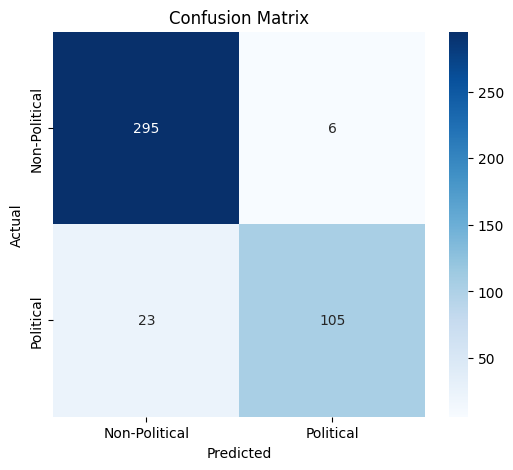


Pipeline Complete.


In [ ]:
import os
import torch
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

warnings.filterwarnings("ignore")

def get_detailed_metrics(model, test_loader, device):
    print("\n==========================================")
    print("Running Comprehensive Test Evaluation")
    print("==========================================")

    model.eval()
    y_true = []
    y_pred = []

    # 1. Inference Loop
    with torch.no_grad():
        with tqdm(test_loader, desc="Testing", unit="batch") as t:
            for batch in t:
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].float().unsqueeze(1).to(device)

                outputs = model(images, input_ids, attention_mask)

                # Probs -> Preds
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

                y_true.extend(labels.cpu().numpy().flatten())
                y_pred.extend(preds.cpu().numpy().flatten())

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # 3. Classification Report (Precision, Recall, F1 per class)
    # Note: 0 = NonPolitical, 1 = Political based on your map
    target_names = ['Non-Political', 'Political']
    report = classification_report(y_true, y_pred, target_names=target_names, digits=4)

    # 4. Overall Metrics
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # --- OUTPUTS ---
    print("\n--- Confusion Matrix ---")
    print(cm)
    print("\n[Row: True, Col: Predicted]")
    print(f"TN: {cm[0][0]} | FP: {cm[0][1]}")
    print(f"FN: {cm[1][0]} | TP: {cm[1][1]}")

    print("\n--- Class-wise Metrics ---")
    print(report)

    print("-" * 30)
    print(f"Final Accuracy: {acc*100:.2f}%")
    print(f"Final Macro F1: {macro_f1:.4f}")
    print("==========================================")

    # Optional: Plot Confusion Matrix if in Notebook
    try:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print("Skipping plot (could not render).")

def main():
    # ==========================================
    # 1. CONFIGURATION
    # ==========================================
    MERGED_CSV_PATH = "/content/drive/MyDrive/CUETPoliMemeDecode/PIXAI/PIXAI_extracted_caption.csv"
    IMAGES_DIR = "/content/drive/MyDrive/CUETPoliMemeDecode/PIXAI/Image"
    SAVE_PATH = "/content/temp"

    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)

    TASK_NAME = "task1"
    MAX_LEN = 64
    BATCH_SIZE = 16
    EPOCHS = 5
    LR_RATE = 2e-5
    NUM_HEADS = 8

    print("==========================================")
    print(f"Initializing Pipeline: Political vs Non-Political")
    print("==========================================")

    # ==========================================
    # 2. DATA LOADING (70-15-15 Split)
    # ==========================================
    train_loader, val_loader, test_loader, class_weights = load_dataset_merged(
        MERGED_CSV_PATH,
        IMAGES_DIR,
        MAX_LEN,
        BATCH_SIZE
    )

    # ==========================================
    # 3. TRAINING
    # ==========================================
    # Train and save the best model
    train(
        train_loader,
        val_loader,
        TASK_NAME,
        SAVE_PATH,
        NUM_HEADS,
        class_weights,
        EPOCHS,
        LR_RATE
    )

    # ==========================================
    # 4. FINAL EVALUATION ON TEST SET
    # ==========================================
    print("\nLoading Best Saved Model for Testing...")

    # 1. Initialize fresh model structure
    best_model = PIXAI(clip_model, num_classes=1, num_heads=NUM_HEADS, max_len=MAX_LEN)
    best_model = best_model.to(device)

    # 2. Load the best weights saved during training
    best_model_path = os.path.join(SAVE_PATH, f'model_{TASK_NAME}.pth')
    checkpoint = torch.load(best_model_path)
    best_model.load_state_dict(checkpoint['model_state_dict'])

    # 3. Run detailed metrics on the Test Loader (15%)
    get_detailed_metrics(best_model, test_loader, device)

    print("\nPipeline Complete.")

if __name__ == "__main__":
    main()

In [ ]:
print("HEY")

HEY


In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
!cp /content/temp/model_task1.pth /content/drive/MyDrive/CUETPoliMemeDecode/PIXAI/models/epoch5